In [17]:
import re
import six
import math
import lmdb
import os
import cv2
import keras_ocr
import numpy as np
import tensorflow as tf
import json

from PIL import Image
import PIL

from IPython.display import display
from keras_ocr.detection import Detector

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt

In [3]:
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


In [4]:
BATCH_SIZE = 128

NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
# 영문 대문자와 숫자를 인식
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


## 데이터셋 확인

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(32, 74, 3)
label:Lube


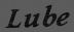

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(32, 84, 3)
label:Spencerian


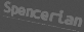

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(32, 100, 3)
label:accommodatingly


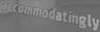

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(32, 100, 3)
label:CARPENTER


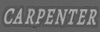

In [5]:
from IPython.display import display

env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

with env.begin(write=False) as txn:
    for index in range(1, 5):
        '''
        LMDB는 키-값 쌍에서 키와 값 모두를 바이트(bytes) 형태로 저장하기 때문에 인코딩과 디코딩 과정이 필요함
        따라서 각 키는 인덱스마다 인코딩하여 전달해야함
        이미지는 버퍼를 통해 읽음
        '''
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지 버퍼 참조 및 디코딩
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿈(단 너비는 100이하)
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size))

        # 이미지와 라벨 출력    
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.astype(np.uint8)))

## 데이터 처리

In [6]:
# 이미지와 라벨을 LMDB에서 꺼내서 모델에 넣기 좋게 전처리하고 배치로 묶음
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2) # (W, H, C)
            
            # label 전처리
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label) # 허용되지 않은 문자 제거
            label = label[:self.max_text_len] # 길이 크롭

        return (img, label)
    
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있음
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img # 너비가 다르면 너비 크기만큼만 이미지 데이터를 넣고, 남은 부분은 0으로 패딩
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

In [7]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         prev_char = None
         for char in text:
             if char == prev_char:
                encoded_label.append(self.label_map['-'])
             encoded_label.append(self.label_map[char])
             prev_char = char

         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [8]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


## 모델 정의

In [9]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [10]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

## 모델학습

### 데이터셋 준비

In [11]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

### 모델 컴파일

In [12]:
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


### 모델 훈련

In [13]:
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

ckp = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_weights_only=True, save_best_only=True, verbose=1)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=30,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop]
)

with open(HOME_DIR + '/training_history.json', 'w') as f:
    json.dump(history.history, f)

Epoch 1/30
565/565 [==============================] - 664s 1s/step - loss: 25.1394 - val_loss: 22.0952

Epoch 00001: val_loss improved from inf to 22.09517, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/30
565/565 [==============================] - 89s 157ms/step - loss: 13.1496 - val_loss: 8.5952

Epoch 00002: val_loss improved from 22.09517 to 8.59522, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/30
565/565 [==============================] - 88s 155ms/step - loss: 6.7164 - val_loss: 6.0277

Epoch 00003: val_loss improved from 8.59522 to 6.02775, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/30
565/565 [==============================] - 88s 155ms/step - loss: 4.9308 - val_loss: 5.1306

Epoch 00004: val_loss improved from 6.02775 to 5.13059, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 5/30
565/565 [==============================] - 88s 156ms/step - loss: 3.9199 - val_loss: 4.5941

Epoch 00005: val_loss improve

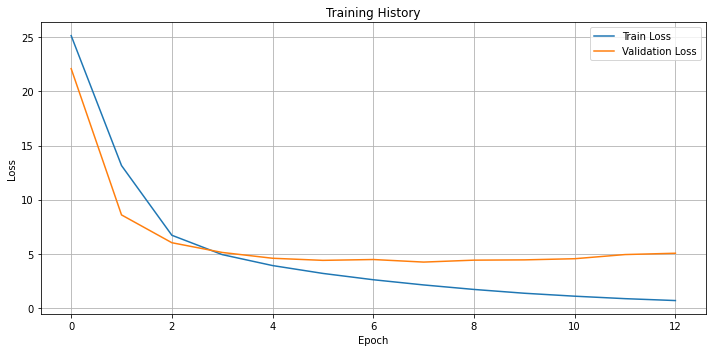

In [18]:
# 훈련 기록 로드
with open(HOME_DIR + '/training_history.json', 'r') as f:
    history = json.load(f)

plt.figure(figsize=(10, 5))

plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')

plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 추론 및 출력

In [19]:
# 기존 학습된 모델의 가중치를 불러옴
# checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5' 

# 테스트 데이터셋 로드
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# 추론용 모델
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING                


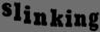

Result: 	 ALEPPO                 


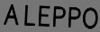

Result: 	 RWANDA                  


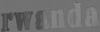

Result: 	 NATHANS                 


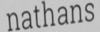

Result: 	 HALK                    


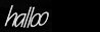

Result: 	 HURLS                   


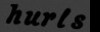

Result: 	 DOWNSIZE                


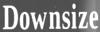

Result: 	 ROBOTIC                 


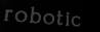

Result: 	 SLOPPY                 


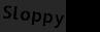

Result: 	 HERMITE                


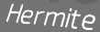

In [20]:
TARGET_CHARACTERS = TARGET_CHARACTERS + " "

# 모델이 inference한 결과를 글자로 바꿔주는 역할
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS + " "
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results


# 모델과 데이터셋이 주어지면 inference를 수행
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩하여 출력
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

## 객체 검출 및 문자 인식 파이프라인 구성
- 이제 원본 이미지에서 객체 검출과 문자 인식을 end-to-end로 수행
- 테스트 샘플로 테스트

In [21]:
SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'
SAMPLE_IMG_dir_IN = os.getenv('HOME') + '/aiffel/AIFFEL_quest_rs/GoingDeeper/Quest06/samples/'

In [22]:
# end - to - end model
class OcrModel():
    def __init__(self):
        self.detector = Detector()
    
    # 객체 검출 함수
    def detect_text(self, img_path):
        with Image.open(img_path) as img:
            img_pil = img.convert("RGB")
            img_np = np.array(img_pil)

        # TODO
        # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
        img_np = np.expand_dims(img_np, axis=0)
        # img_np = np.transpose(img_np, axes=[0,2,1,3])

        # 배치의 첫 번째 결과만 가져옵니다.
        ocr_result = self.detector.detect(img_np)[0] 
        # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
        # for i in range(len(ocr_result)):
        #     ocr_result[i] = np.array(ocr_result[i])[:, ::-1]

        # 시각화를 위한 드로잉 객체
        result_img = img_pil.copy()
        img_draw = PIL.ImageDraw.Draw(result_img)

        cropped_imgs = []
        for text_result in ocr_result:
            img_draw.polygon(text_result, outline='red')
            x_min = text_result[:,0].min() - 5
            x_max = text_result[:,0].max() + 5
            y_min = text_result[:,1].min() - 5
            y_max = text_result[:,1].max() + 5
            word_box = [x_min, y_min, x_max, y_max]
            cropped_imgs.append(img_pil.crop(word_box))

        return result_img, cropped_imgs
    
    def recognize_text(self, pil_img, input_img_size=(100,32)):
        for img_pil in pil_img:
            width, height = img_pil.size

            target_width = min(int(width*input_img_size[1]/height), input_img_size[0])
            target_img_size = (target_width, input_img_size[1])
            img = np.array(img_pil.resize(target_img_size)).transpose(1,0,2)

            input_images = np.zeros([*input_img_size,3])
            input_images[:target_width,:,:] = img # 너비가 다르면 너비 크기만큼만 이미지 데이터를 넣고, 남은 부분은 0으로 패딩(크롭된 이미지는 배치를 이룸)
            input_images = np.expand_dims(input_images, 0)
            
            output = model_pred.predict(input_images)
            result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
            print("Result: \t", result)
            display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))
            
    def predict(self, image_path):
        img_pil, cropped_imgs = self.detect_text(image_path)
        self.recognize_text(cropped_imgs)
        
    # debugging
    def display_detect_text(self, image_path):
        img_pil, cropped_imgs = self.detect_text(image_path)
        display(img_pil)

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


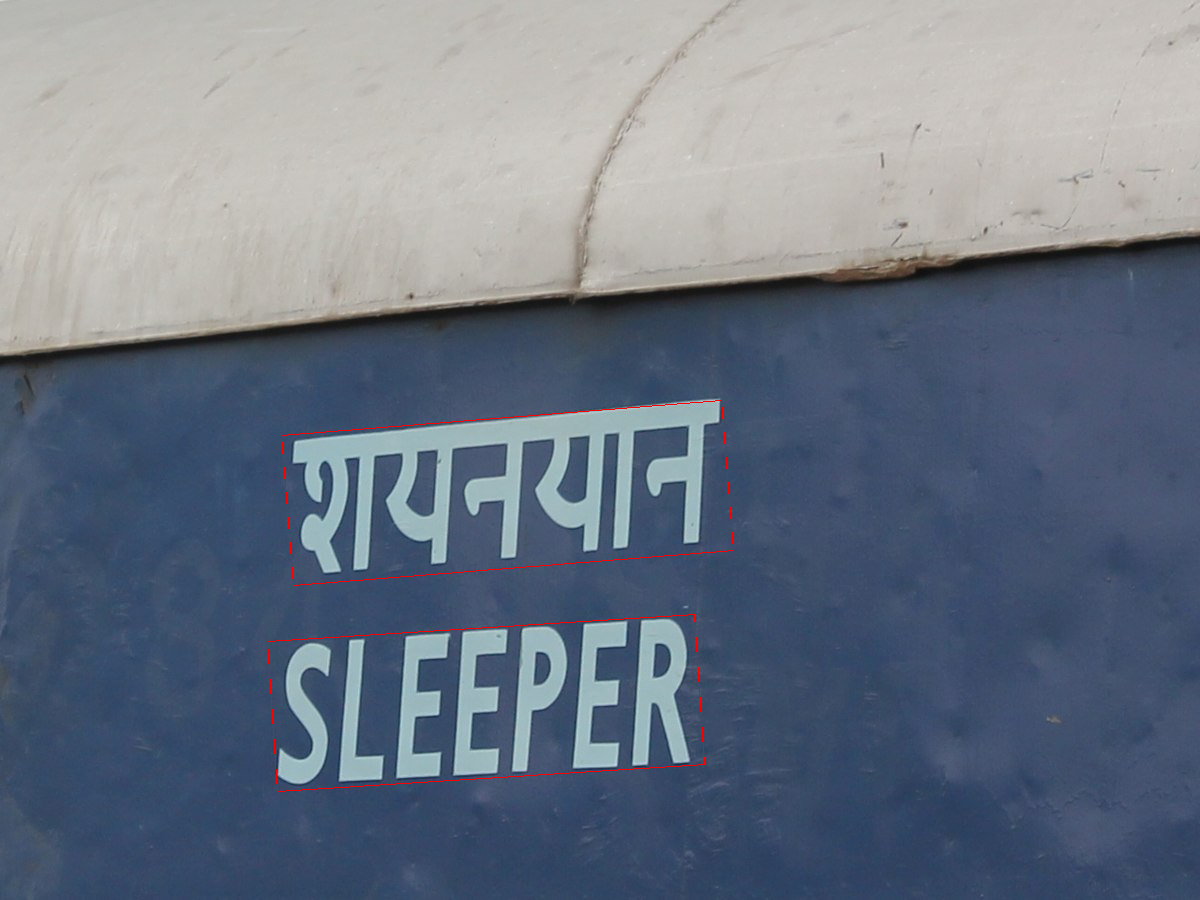

Result: 	 TATIT                   


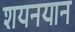

Result: 	 SLEEPER                


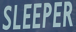

In [23]:
ocr = OcrModel()
ocr.display_detect_text(SAMPLE_IMG_PATH)
ocr.predict(SAMPLE_IMG_PATH)

### 문제점 1
- 위 아랍어는 학습데이터에 없었기 때문에 올바르지 않은 결과를 낸 것이다.
- 훈련 세트가 실제 테스트 세트를 대표하지 못하기 때문이다.

## 인터넷에서 구한 이미지 데이터로 테스트

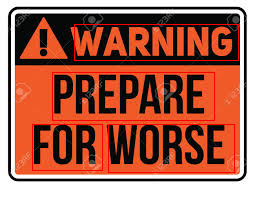

Result: 	 WARAG                  


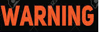

Result: 	 FIETANE                 


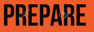

Result: 	 EER                    


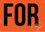

Result: 	 TFERSE                  


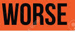

In [24]:
ocr.display_detect_text(SAMPLE_IMG_dir_IN + 'sample2.jpeg')
ocr.predict(SAMPLE_IMG_dir_IN + 'sample2.jpeg')

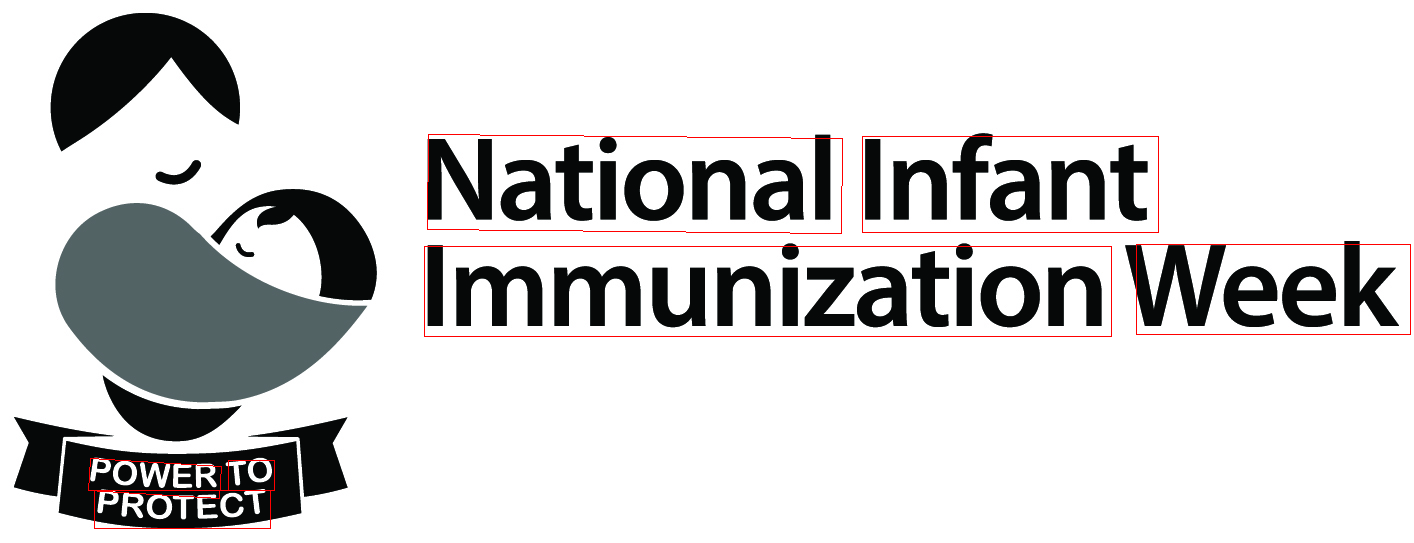

Result: 	 NATIONAL                


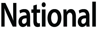

Result: 	 LINFANT                 


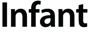

Result: 	 VEEK                   


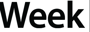

Result: 	 LIMMUNIZATION          


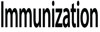

Result: 	 FOWER                   


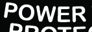

Result: 	 TO                      


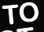

Result: 	 PROTECT                 


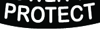

In [25]:
ocr.display_detect_text(SAMPLE_IMG_dir_IN + 'sample3.jpg')
ocr.predict(SAMPLE_IMG_dir_IN + 'sample3.jpg')

### 문제점 2
- 위 결과를 보면 컬러 이미지는 그레이 스케일 이미지보다 정확성이 떨어지는 것을 알 수 있다.
- 이는 학습데이터가 실제 환경의 컬러 이미지가 아닌 그레이 스케일 이미지이기 때문이다.

#### 해결 방안
- 가장 간단한 방법은 입력 이미지에 대해 먼저 그레이 스케일로 변환하는 전처리를 추가해주는 것이다.
- 입력 이미지를 그레이스케일로 변환하는 Ocr 모델로 테스트 해보자.

In [26]:
class OcrModel_grayscale():
    def __init__(self):
        self.detector = Detector()
    
    # 객체 검출 함수
    def detect_text(self, img_path):
        with Image.open(img_path) as img:
            img_color = img.convert("RGB")
            img_gray = img_color.convert('L')  # 'L' 모드는 8-bit 그레이스케일
            img_gray_rgb = img_gray.convert('RGB')
            img_np = np.array(img_gray_rgb)

        # TODO
        # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
        img_np = np.expand_dims(img_np, axis=0)
        # img_np = np.transpose(img_np, axes=[0,2,1,3])

        # 배치의 첫 번째 결과만 가져옵니다.
        ocr_result = self.detector.detect(img_np)[0] 
        # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
        # for i in range(len(ocr_result)):
        #     ocr_result[i] = np.array(ocr_result[i])[:, ::-1]

        # 시각화를 위한 드로잉 객체
        result_img = img_gray_rgb.copy()
        img_draw = PIL.ImageDraw.Draw(result_img)

        cropped_imgs = []
        for text_result in ocr_result:
            img_draw.polygon(text_result, outline='red')
            x_min = text_result[:,0].min() - 5
            x_max = text_result[:,0].max() + 5
            y_min = text_result[:,1].min() - 5
            y_max = text_result[:,1].max() + 5
            word_box = [x_min, y_min, x_max, y_max]
            cropped_imgs.append(img_gray_rgb.crop(word_box))

        return result_img, cropped_imgs
    
    def recognize_text(self, pil_img, input_img_size=(100,32)):
        for img_pil in pil_img:
            width, height = img_pil.size

            target_width = min(int(width*input_img_size[1]/height), input_img_size[0])
            target_img_size = (target_width, input_img_size[1])
            img = np.array(img_pil.resize(target_img_size)).transpose(1,0,2)

            input_images = np.zeros([*input_img_size,3])
            input_images[:target_width,:,:] = img # 너비가 다르면 너비 크기만큼만 이미지 데이터를 넣고, 남은 부분은 0으로 패딩(크롭된 이미지는 배치를 이룸)
            input_images = np.expand_dims(input_images, 0)
            
            output = model_pred.predict(input_images)
            result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
            print("Result: \t", result)
            display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))
            
    def predict(self, image_path):
        img_pil, cropped_imgs = self.detect_text(image_path)
        self.recognize_text(cropped_imgs)
        
    # debugging
    def display_detect_text(self, image_path):
        img_pil, cropped_imgs = self.detect_text(image_path)
        display(img_pil)

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


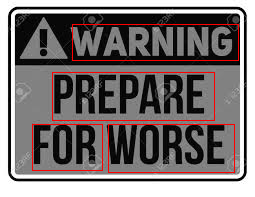

Result: 	 WARNING                 


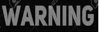

Result: 	 PREPARE                 


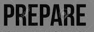

Result: 	 FOR                     


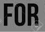

Result: 	 WORSE                   


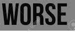

In [27]:
ocr_gray = OcrModel_grayscale()
ocr_gray.display_detect_text(SAMPLE_IMG_dir_IN + 'sample2.jpeg')
ocr_gray.predict(SAMPLE_IMG_dir_IN + 'sample2.jpeg')

간단한 방법으로 전보다는 높은 정확도를 내는 것을 알 수 있다.

## 회고
- 문자 인식을 위한 CRNN 모델을 구현하여 직접 OCR 모델을 구현해보았다.
- CTC 기법이 내가 이해한 부분이랑 코드 구현한 부분이랑 약간 차이가 있는데 이부분에 대해선 더 공부가 필요할 거 같다.